In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.test.is_built_with_cuda()

True

# Importing Libraries

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras import backend as K
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

# Data Fetching

In [12]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# Min Max Scaler

In [13]:
from sklearn.preprocessing import MinMaxScaler
import warnings
scaler_obj=MinMaxScaler()
X1=scaler_obj.fit_transform(A1)
Y1=scaler_obj.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [14]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Model

In [6]:
inp=keras.Input(shape=(1,5))

l=keras.layers.Conv1D(16,1,padding="same",activation="relu",kernel_initializer="glorot_uniform")(inp)
 
output = keras.layers.Conv1D(7,4,padding="same",activation='sigmoid')(l)

model1=keras.Model(inputs=inp,outputs=output)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='mse',metrics=['accuracy','mse','mae',rmse])
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 5)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 16)             96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 7)              455       
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

history1 = model1.fit(x_train,y_train,batch_size=2048,epochs=250, validation_data=(x_test, y_test),verbose = 2, shuffle= False)

Epoch 1/250
634/634 - 3s - loss: 0.2479 - accuracy: 0.0358 - mse: 0.2479 - mae: 0.4967 - rmse: 0.4978 - val_loss: 0.2454 - val_accuracy: 2.0806e-05 - val_mse: 0.2454 - val_mae: 0.4942 - val_rmse: 0.4953
Epoch 2/250
634/634 - 2s - loss: 0.2429 - accuracy: 3.4676e-05 - mse: 0.2429 - mae: 0.4917 - rmse: 0.4928 - val_loss: 0.2404 - val_accuracy: 2.0806e-05 - val_mse: 0.2404 - val_mae: 0.4891 - val_rmse: 0.4903
Epoch 3/250
634/634 - 3s - loss: 0.2380 - accuracy: 3.4676e-05 - mse: 0.2380 - mae: 0.4866 - rmse: 0.4878 - val_loss: 0.2354 - val_accuracy: 2.0806e-05 - val_mse: 0.2354 - val_mae: 0.4839 - val_rmse: 0.4852
Epoch 4/250
634/634 - 3s - loss: 0.2330 - accuracy: 3.4676e-05 - mse: 0.2330 - mae: 0.4814 - rmse: 0.4826 - val_loss: 0.2305 - val_accuracy: 2.0806e-05 - val_mse: 0.2305 - val_mae: 0.4787 - val_rmse: 0.4800
Epoch 5/250
634/634 - 3s - loss: 0.2280 - accuracy: 3.3906e-05 - mse: 0.2280 - mae: 0.4761 - rmse: 0.4774 - val_loss: 0.2254 - val_accuracy: 2.0806e-05 - val_mse: 0.2254 - val_

Epoch 41/250
634/634 - 2s - loss: 0.0399 - accuracy: 3.3906e-05 - mse: 0.0399 - mae: 0.1883 - rmse: 0.1950 - val_loss: 0.0382 - val_accuracy: 2.0806e-05 - val_mse: 0.0382 - val_mae: 0.1839 - val_rmse: 0.1907
Epoch 42/250
634/634 - 2s - loss: 0.0366 - accuracy: 3.3906e-05 - mse: 0.0366 - mae: 0.1795 - rmse: 0.1863 - val_loss: 0.0351 - val_accuracy: 2.0806e-05 - val_mse: 0.0351 - val_mae: 0.1752 - val_rmse: 0.1821
Epoch 43/250
634/634 - 2s - loss: 0.0336 - accuracy: 3.3906e-05 - mse: 0.0336 - mae: 0.1708 - rmse: 0.1778 - val_loss: 0.0322 - val_accuracy: 2.0806e-05 - val_mse: 0.0322 - val_mae: 0.1667 - val_rmse: 0.1737
Epoch 44/250
634/634 - 2s - loss: 0.0307 - accuracy: 3.3906e-05 - mse: 0.0307 - mae: 0.1625 - rmse: 0.1695 - val_loss: 0.0294 - val_accuracy: 2.0806e-05 - val_mse: 0.0294 - val_mae: 0.1584 - val_rmse: 0.1655
Epoch 45/250
634/634 - 2s - loss: 0.0281 - accuracy: 3.3906e-05 - mse: 0.0281 - mae: 0.1543 - rmse: 0.1614 - val_loss: 0.0269 - val_accuracy: 2.0806e-05 - val_mse: 0.02

Epoch 81/250
634/634 - 2s - loss: 9.3802e-04 - accuracy: 0.9438 - mse: 9.3802e-04 - mae: 0.0209 - rmse: 0.0233 - val_loss: 9.0042e-04 - val_accuracy: 0.9435 - val_mse: 9.0042e-04 - val_mae: 0.0205 - val_rmse: 0.0228
Epoch 82/250
634/634 - 2s - loss: 8.6001e-04 - accuracy: 0.9438 - mse: 8.6001e-04 - mae: 0.0199 - rmse: 0.0223 - val_loss: 8.2596e-04 - val_accuracy: 0.9435 - val_mse: 8.2596e-04 - val_mae: 0.0195 - val_rmse: 0.0218
Epoch 83/250
634/634 - 2s - loss: 7.8935e-04 - accuracy: 0.9438 - mse: 7.8935e-04 - mae: 0.0190 - rmse: 0.0213 - val_loss: 7.5855e-04 - val_accuracy: 0.9435 - val_mse: 7.5855e-04 - val_mae: 0.0186 - val_rmse: 0.0209
Epoch 84/250
634/634 - 2s - loss: 7.2541e-04 - accuracy: 0.9438 - mse: 7.2541e-04 - mae: 0.0181 - rmse: 0.0204 - val_loss: 6.9758e-04 - val_accuracy: 0.9435 - val_mse: 6.9758e-04 - val_mae: 0.0177 - val_rmse: 0.0200
Epoch 85/250
634/634 - 2s - loss: 6.6762e-04 - accuracy: 0.9438 - mse: 6.6762e-04 - mae: 0.0172 - rmse: 0.0195 - val_loss: 6.4250e-04 - 

Epoch 119/250
634/634 - 2s - loss: 1.5904e-04 - accuracy: 0.9438 - mse: 1.5904e-04 - mae: 0.0055 - rmse: 0.0080 - val_loss: 1.5804e-04 - val_accuracy: 0.9435 - val_mse: 1.5804e-04 - val_mae: 0.0054 - val_rmse: 0.0080
Epoch 120/250
634/634 - 2s - loss: 1.5685e-04 - accuracy: 0.9438 - mse: 1.5685e-04 - mae: 0.0054 - rmse: 0.0079 - val_loss: 1.5590e-04 - val_accuracy: 0.9435 - val_mse: 1.5590e-04 - val_mae: 0.0054 - val_rmse: 0.0079
Epoch 121/250
634/634 - 3s - loss: 1.5480e-04 - accuracy: 0.9438 - mse: 1.5480e-04 - mae: 0.0053 - rmse: 0.0079 - val_loss: 1.5390e-04 - val_accuracy: 0.9435 - val_mse: 1.5390e-04 - val_mae: 0.0053 - val_rmse: 0.0079
Epoch 122/250
634/634 - 3s - loss: 1.5288e-04 - accuracy: 0.9438 - mse: 1.5288e-04 - mae: 0.0053 - rmse: 0.0079 - val_loss: 1.5203e-04 - val_accuracy: 0.9435 - val_mse: 1.5203e-04 - val_mae: 0.0053 - val_rmse: 0.0079
Epoch 123/250
634/634 - 3s - loss: 1.5108e-04 - accuracy: 0.9438 - mse: 1.5108e-04 - mae: 0.0053 - rmse: 0.0079 - val_loss: 1.5028e-

Epoch 157/250
634/634 - 3s - loss: 1.2814e-04 - accuracy: 0.9438 - mse: 1.2814e-04 - mae: 0.0044 - rmse: 0.0071 - val_loss: 1.2791e-04 - val_accuracy: 0.9435 - val_mse: 1.2791e-04 - val_mae: 0.0044 - val_rmse: 0.0071
Epoch 158/250
634/634 - 3s - loss: 1.2797e-04 - accuracy: 0.9438 - mse: 1.2797e-04 - mae: 0.0044 - rmse: 0.0071 - val_loss: 1.2774e-04 - val_accuracy: 0.9435 - val_mse: 1.2774e-04 - val_mae: 0.0044 - val_rmse: 0.0071
Epoch 159/250
634/634 - 3s - loss: 1.2781e-04 - accuracy: 0.9438 - mse: 1.2781e-04 - mae: 0.0044 - rmse: 0.0071 - val_loss: 1.2759e-04 - val_accuracy: 0.9435 - val_mse: 1.2759e-04 - val_mae: 0.0044 - val_rmse: 0.0071
Epoch 160/250
634/634 - 3s - loss: 1.2767e-04 - accuracy: 0.9438 - mse: 1.2767e-04 - mae: 0.0043 - rmse: 0.0071 - val_loss: 1.2744e-04 - val_accuracy: 0.9435 - val_mse: 1.2744e-04 - val_mae: 0.0043 - val_rmse: 0.0071
Epoch 161/250
634/634 - 3s - loss: 1.2753e-04 - accuracy: 0.9438 - mse: 1.2753e-04 - mae: 0.0043 - rmse: 0.0071 - val_loss: 1.2731e-

Epoch 195/250
634/634 - 3s - loss: 1.2542e-04 - accuracy: 0.9438 - mse: 1.2542e-04 - mae: 0.0041 - rmse: 0.0068 - val_loss: 1.2522e-04 - val_accuracy: 0.9435 - val_mse: 1.2522e-04 - val_mae: 0.0041 - val_rmse: 0.0068
Epoch 196/250
634/634 - 2s - loss: 1.2538e-04 - accuracy: 0.9438 - mse: 1.2538e-04 - mae: 0.0041 - rmse: 0.0068 - val_loss: 1.2519e-04 - val_accuracy: 0.9435 - val_mse: 1.2519e-04 - val_mae: 0.0041 - val_rmse: 0.0068
Epoch 197/250
634/634 - 2s - loss: 1.2535e-04 - accuracy: 0.9438 - mse: 1.2535e-04 - mae: 0.0041 - rmse: 0.0068 - val_loss: 1.2516e-04 - val_accuracy: 0.9435 - val_mse: 1.2516e-04 - val_mae: 0.0041 - val_rmse: 0.0068
Epoch 198/250
634/634 - 3s - loss: 1.2532e-04 - accuracy: 0.9438 - mse: 1.2532e-04 - mae: 0.0041 - rmse: 0.0068 - val_loss: 1.2513e-04 - val_accuracy: 0.9435 - val_mse: 1.2513e-04 - val_mae: 0.0041 - val_rmse: 0.0068
Epoch 199/250
634/634 - 3s - loss: 1.2529e-04 - accuracy: 0.9438 - mse: 1.2529e-04 - mae: 0.0041 - rmse: 0.0068 - val_loss: 1.2510e-

Epoch 233/250
634/634 - 2s - loss: 1.2444e-04 - accuracy: 0.9438 - mse: 1.2444e-04 - mae: 0.0041 - rmse: 0.0067 - val_loss: 1.2424e-04 - val_accuracy: 0.9435 - val_mse: 1.2424e-04 - val_mae: 0.0041 - val_rmse: 0.0067
Epoch 234/250
634/634 - 2s - loss: 1.2441e-04 - accuracy: 0.9438 - mse: 1.2441e-04 - mae: 0.0041 - rmse: 0.0067 - val_loss: 1.2421e-04 - val_accuracy: 0.9435 - val_mse: 1.2421e-04 - val_mae: 0.0041 - val_rmse: 0.0067
Epoch 235/250
634/634 - 2s - loss: 1.2439e-04 - accuracy: 0.9438 - mse: 1.2439e-04 - mae: 0.0041 - rmse: 0.0067 - val_loss: 1.2419e-04 - val_accuracy: 0.9435 - val_mse: 1.2419e-04 - val_mae: 0.0041 - val_rmse: 0.0067
Epoch 236/250
634/634 - 2s - loss: 1.2437e-04 - accuracy: 0.9438 - mse: 1.2437e-04 - mae: 0.0041 - rmse: 0.0067 - val_loss: 1.2417e-04 - val_accuracy: 0.9435 - val_mse: 1.2417e-04 - val_mae: 0.0041 - val_rmse: 0.0067
Epoch 237/250
634/634 - 2s - loss: 1.2434e-04 - accuracy: 0.9438 - mse: 1.2434e-04 - mae: 0.0041 - rmse: 0.0067 - val_loss: 1.2415e-

# Saving Model as File

In [8]:
model_json = model1.to_json()
with open("Model_File/cnn_relu.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("Model_File/cnn_relu.h5")
print("Saved model to disk")

Saved model to disk


In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('Model_File/cnn_relu.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Model_File/cnn_relu.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='mse',metrics=['accuracy','mse','mae',rmse])

Loaded model from disk


In [16]:
loaded_model.evaluate(x_train, y_train, verbose=0)

[0.00012404395965859294,
 0.9438334107398987,
 0.00012404395965859294,
 0.004049819894134998,
 0.006706115324050188]

In [19]:
loaded_model.evaluate(x_test, y_test, verbose=0)

[0.00012385364971123636,
 0.9434844255447388,
 0.00012385364971123636,
 0.004055249970406294,
 0.006716000847518444]

# Error Analysis

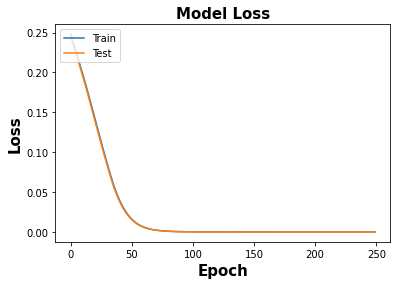

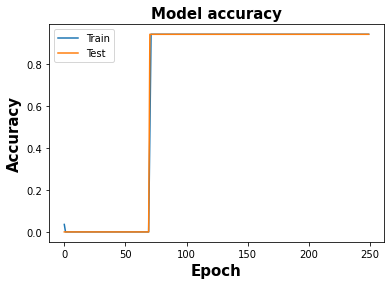

In [9]:
# _, train_acc = model1.evaluate(x_train, y_train, verbose=0)
# _, test_acc = model1.evaluate(x_test, y_test, verbose=0)
# print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss',fontweight ='bold',fontsize = 15)
plt.ylabel('Loss',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy',fontweight ='bold',fontsize = 15)
plt.ylabel('Accuracy',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=loaded_model.predict(x_test)
y_test_pred

array([[[0.00018728, 0.06549126, 0.00017226, ..., 0.00469372,
         0.00323826, 0.00144804]],

       [[0.00021988, 0.06355608, 0.00023842, ..., 0.02103931,
         0.01342556, 0.00466657]],

       [[0.00025117, 0.06567246, 0.00027096, ..., 0.02152359,
         0.01385072, 0.00491521]],

       ...,

       [[0.00028068, 0.0672043 , 0.00030443, ..., 0.02398524,
         0.01546434, 0.00549221]],

       [[0.00017908, 0.06478921, 0.00016466, ..., 0.00454554,
         0.00313008, 0.00139585]],

       [[0.0002546 , 0.06571296, 0.00027749, ..., 0.02379107,
         0.01525125, 0.00533122]]], dtype=float32)

In [26]:
y_test

array([[[0.00011559, 0.06553685, 0.00011085, ..., 0.0021448 ,
         0.0014142 , 0.00052142]],

       [[0.00011088, 0.06553695, 0.00012144, ..., 0.01090628,
         0.00639894, 0.00234271]],

       [[0.0001138 , 0.06553686, 0.00011756, ..., 0.02938369,
         0.01855402, 0.00761428]],

       ...,

       [[0.00011103, 0.06553663, 0.00011547, ..., 0.05674056,
         0.03595096, 0.01243099]],

       [[0.00011477, 0.06553688, 0.00010965, ..., 0.00815022,
         0.00468672, 0.00148292]],

       [[0.00010879, 0.06553657, 0.00012025, ..., 0.00375339,
         0.00246608, 0.00081172]]], dtype=float32)

In [27]:
y_test=y_test[:,0]
y_test_pred=y_test_pred[:,0]

In [29]:
from numpy import savetxt
savetxt('ARRAY_DATA/cnn_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [30]:
from numpy import savetxt
savetxt('ARRAY_DATA/cnn_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed